In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

def model(true_model_coefficients, X):
    """
    Calculates the value of y for case study 1
    
    Parameters
    ----------
    true_model_coefficients: ndarray, The array containing the true values of Theta1 and Theta2
    x: ndarray, The list of xs that will be used to generate y
    
    Returns
    --------
    y_poly: ndarray, The noiseless values of y given theta_true and x
    """
    assert len(true_model_coefficients) == 5, "5 Coefficients"
    t1, t2, t3, t4, t5 = true_model_coefficients
    
    y_model = np.zeros(len(X))
    #If array is not 2D, give it shape (len(array), 1)
    for i in range(len(X)):
        x = X[i]
        #If array is not 2D, give it shape (len(array), 1)
        if not len(x.shape) > 1:
            x = x.reshape(-1,1)

        assert x.shape[0] == 2, "Polynomial x_data must be 2 dimensional"
        x1, x2 = x #Split x into 2 parts by splitting the rows

        y_model[i] =  t1*x1 + t2*x2 + t3*x1*x2 + t4*x1**2 + t5*x2**2
        
    y_model = np.array(y_model)
       
    return y_model

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta, X, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        x: independent variable vector
        y: dependent variable vector (measurements)
    Returns:
        e: residual vector
    '''
    
    error = y - model(theta,X); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error
#New Cell

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - model(theta,x))**2) 
    
    return sse

In [2]:
%%time
# Create synthetic data assuming the following values for theta
Theta_Guess = np.array([-100, 1.0, -0.1, 10, -10])
theta_ref = np.array([-100, 1.0, -0.1, 10, -10])
##New Cell

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
num_points = 5
bounds_x = np.array([[-5, -5], 
                     [5, 5]])
Xexp = grid_sampling(num_points, bounds_x)
theta_ref = np.array([100, -1.0, 10, 0.1, -10]) 
Yexp = model(theta_ref, Xexp)

# Evaluate model based on the assumed experimental values
num_points_2 = 10
X = grid_sampling(num_points_2, bounds_x)
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),num_points_2)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),num_points_2)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
# #Creates an array for Y that will be filled with the for loop
# #Initialize y_sim
Y = model(theta_ref, X)

CPU times: user 5.14 ms, sys: 28 µs, total: 5.17 ms
Wall time: 5.05 ms


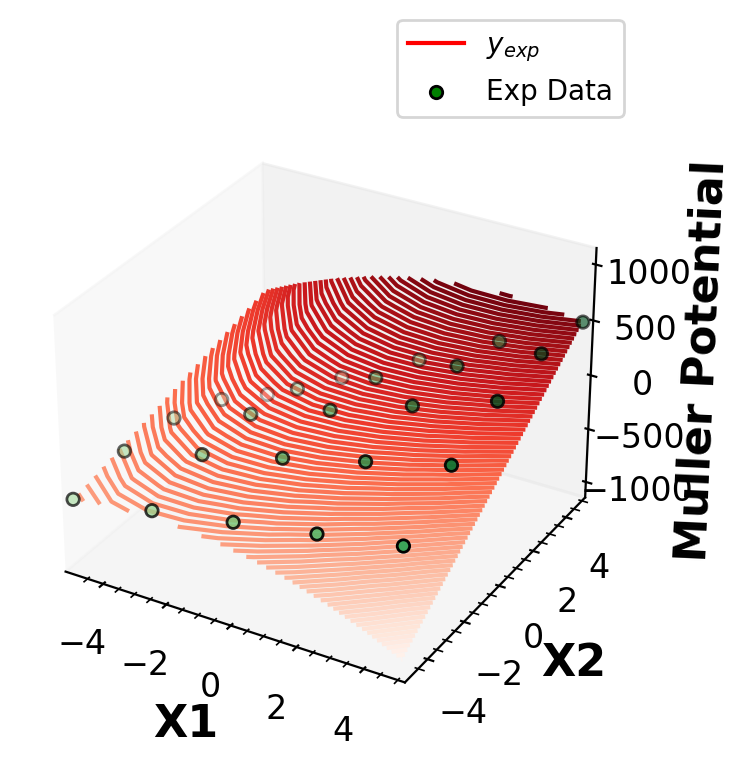

In [3]:
# Compare the experiments to the true model
# Compare the experiments to the true model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y.reshape(num_points_2,-1), 100, cmap='Reds')
ax.plot(1000,1000,1000, label = "$y_{exp}$", color = 'red')
ax.scatter(1000,1000,1000, label = "Exp Data", color = 'green', edgecolors = "k")
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', edgecolors = "k")
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.0, 1, 0.2),borderaxespad=0, loc = "lower right")

ax.minorticks_on() # turn on minor ticks
ax.tick_params(direction="in",top=True, right=True) 
ax.tick_params(which="minor",direction="in",top=True, right=True)


ax.zaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.grid(False)

ax.set_xlim((np.amin(X1),np.amax(X1)))
ax.set_ylim((np.amin(X2),np.amax(X2)))

ax.set_xlabel('X1', fontsize=16,fontweight='bold')
ax.set_ylabel('X2', fontsize=16,fontweight='bold')
ax.set_zlabel('Muller Potential',fontsize=16,fontweight='bold');

ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='z', nbins=5)
# plt.title("Plotting True Model and Synthetic Data")
plt.show()

[-5.  5.]


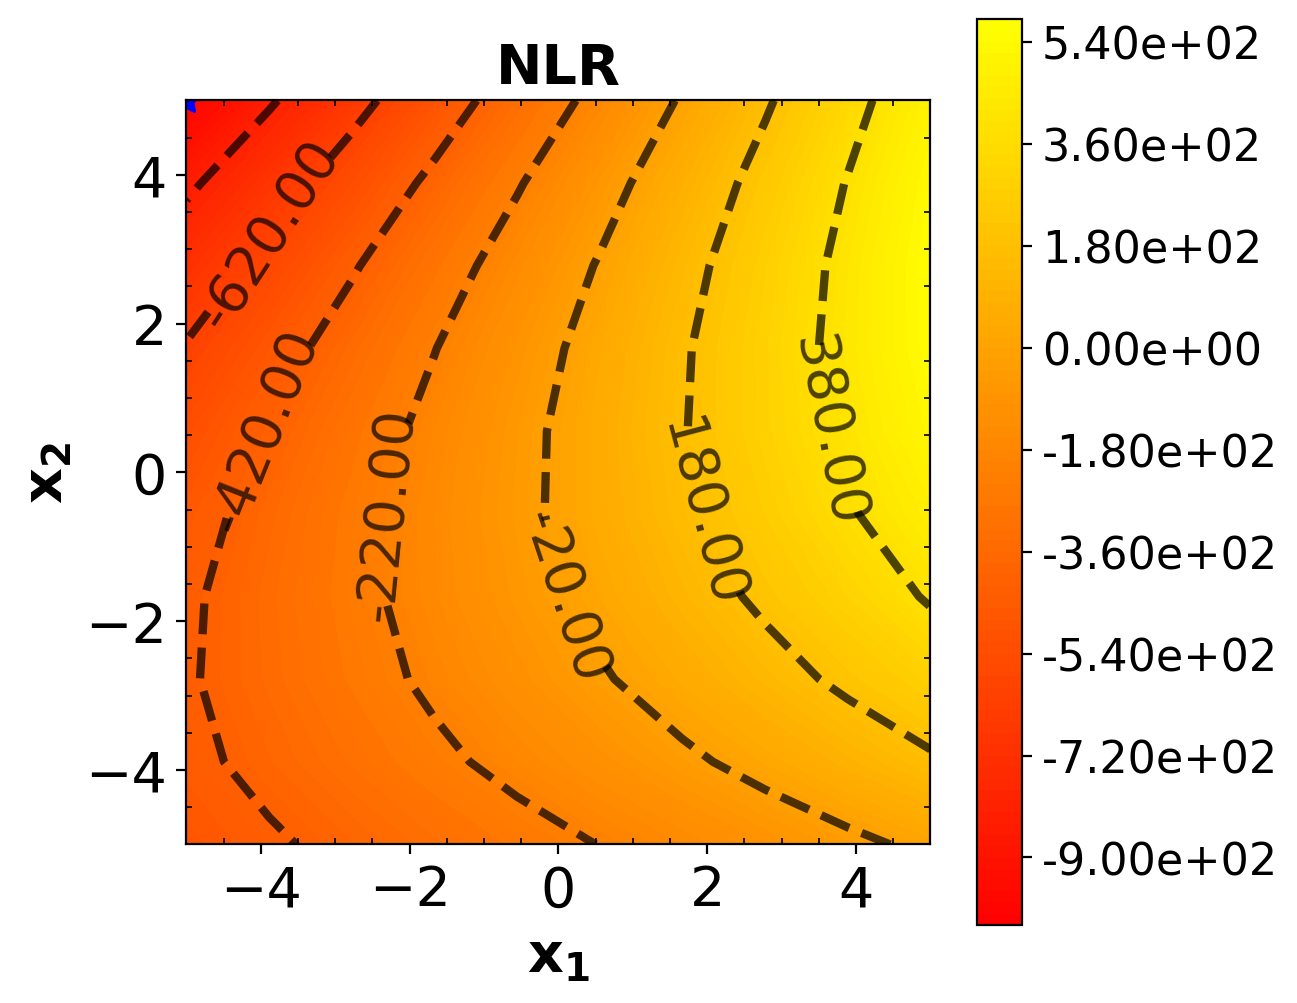

In [4]:
zz = Y.reshape(num_points_2,-1).T
xx = X1
yy = X2

plt.figure(figsize = (6,6))

cs = plt.contourf(xx, yy,zz, levels = 100, cmap = "autumn")

# plot color bar
if np.amax(zz) < 1e-1 or np.amax(zz) > 1e2:
    cbar = plt.colorbar(cs, format='%.2e')
else:
    cbar = plt.colorbar(cs, format = '%2.2f')

#set font size in color bar
cbar.ax.tick_params(labelsize=16)

# plot title in color bar
# cbar.ax.set_ylabel(r'$\mathbf{log(e(\theta))}$', fontsize=16, fontweight='bold')
#     print(p_GP_opt[0],p_GP_opt[1])



# Plot equipotential line
cs2 = plt.contour(cs, levels=cs.levels[::10], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

if np.amax(zz) < 1e-1:
    plt.clabel(cs2, fmt='%.2e', colors='k', fontsize=20)
else:
    plt.clabel(cs2, fmt='%2.2f', colors='k', fontsize=20)

X_best = np.array(X_mesh).T.reshape(-1,2)[np.argmin(Y)]
print(X_best)
plt.scatter(X_best[0],X_best[1], color="blue", s=100, label = "True Optimal Value", marker = (5,1))
# plt.scatter(theta[0],theta[1], color="white",s=50, marker = ".",label = "NLR Optimal Value", edgecolor = "k", linewidth=0.3)
# plt.grid()

# plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower left")
plt.xlabel(r'$\mathbf{x_1}$',fontsize=20,fontweight='bold')
plt.ylabel(r'$\mathbf{x_2}$',fontsize=20,fontweight='bold')
plt.xlim((np.amin(xx), np.amax(xx)))
plt.ylim((np.amin(yy),np.amax(yy))) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.axis('square')
# plt.title("log(sse)", fontweight = "bold", fontsize = 24)

if log_plot == True:
    plt.title(r'$\mathbf{log(e(\theta))}$', weight='bold',fontsize = 24)
    plt.title("NLR", weight='bold',fontsize = 20)
#     plt.savefig("Figures/NLR_ln_SSE_poster.png", dpi=300, bbox_inches='tight')
else:
    plt.title('Non-Linear Regression SSE', weight='bold',fontsize = 16)
#     plt.savefig("Figures/NLR_SSE.png", dpi=300, bbox_inches='tight')
    

plt.show()

In [ ]:
%%time
#New Cell

## specify initial guess
# sse_list = []
# for i in range(15):
theta0 = np.array([200, -5, 20, 0, -1])
#     theta0 = Theta_Guess
#     print(theta0)

## specify bounds
# first array: lower bounds
# second array: upper bounds
bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf])

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
Solution = optimize.least_squares(regression_func, theta0, bounds=bounds, method='trf',args=(Xexp, Yexp),verbose=2)

theta = Solution.x
print("theta = ",theta)
    
#     Y_pred2 = model(theta,Xexp)
#     error = (Yexp - Y_pred2)
#     sse_list.append(np.sum(error**2))

# sse_list = np.array(sse_list)
# print(np.median(sse_list))
# print(np.argmin(sse_list))

In [ ]:
Y = model(theta, X)
zz = Y.reshape(num_points_2,-1).T
xx = X1
yy = X2

plt.figure(figsize = (6,6))

cs = plt.contourf(xx, yy,zz, levels = 100, cmap = "autumn")

# plot color bar
if np.amax(zz) < 1e-1:
    cbar = plt.colorbar(cs, format='%.2e')
else:
    cbar = plt.colorbar(cs, format = '%2.2f')

#set font size in color bar
cbar.ax.tick_params(labelsize=16)

# plot title in color bar
# cbar.ax.set_ylabel(r'$\mathbf{log(e(\theta))}$', fontsize=16, fontweight='bold')
#     print(p_GP_opt[0],p_GP_opt[1])



# Plot equipotential line
cs2 = plt.contour(cs, levels=cs.levels[::10], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

if np.amax(zz) < 1e-1:
    plt.clabel(cs2, fmt='%.2e', colors='k', fontsize=20)
else:
    plt.clabel(cs2, fmt='%2.2f', colors='k', fontsize=20)

X_best = np.array(X_mesh).T.reshape(-1,2)[np.argmin(Y)]
print(X_best)
plt.scatter(X_best[0],X_best[1], color="blue", s=100, label = "True Optimal Value", marker = (5,1))
# plt.scatter(theta[0],theta[1], color="white",s=50, marker = ".",label = "NLR Optimal Value", edgecolor = "k", linewidth=0.3)
# plt.grid()

# plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower left")
# plt.xlabel(r'$\mathbf{\theta_1}$',fontsize=20,fontweight='bold')
# plt.ylabel(r'$\mathbf{\theta_2}$',fontsize=20,fontweight='bold')
plt.xlim((np.amin(xx), np.amax(xx)))
plt.ylim((np.amin(yy),np.amax(yy))) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.axis('square')
# plt.title("log(sse)", fontweight = "bold", fontsize = 24)

if log_plot == True:
    plt.title(r'$\mathbf{log(e(\theta))}$', weight='bold',fontsize = 24)
    plt.title("NLR", weight='bold',fontsize = 20)
#     plt.savefig("Figures/NLR_ln_SSE_poster.png", dpi=300, bbox_inches='tight')
else:
    plt.title('Non-Linear Regression SSE', weight='bold',fontsize = 16)
#     plt.savefig("Figures/NLR_SSE.png", dpi=300, bbox_inches='tight')
    

plt.show()

In [ ]:
#Plot error
Y_pred2 = model(theta,Xexp)
error = (Yexp - Y_pred2)
print("SSE = ", np.sum(error**2))

#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)